In [150]:
import pandas as pd
import pydicom
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Load the CSV file with annotations
annotations_csv = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\Data\1_Initial_Manual_Labeling.csv"  # Replace with the path to your CSV file
annotations_df = pd.read_csv(annotations_csv)


# Directory containing DICOM images from the CQ500 dataset
dicom_dir = r"E:\UOM\Academic\Semester 5\Image processing and machine vision\Project\aria2-1.36.0-win-64bit-build1\aria2-1.36.0-win-64bit-build1\aria2-1.36\CQ500CT10 CQ500CT10"

# Create a dictionary to map SOP Instance UIDs to DICOM file paths
sop_uid_to_filepath = {}
for root, dirs, files in os.walk(dicom_dir):
    for file in files:
        if file.endswith(".dcm"):
            dicom_file_path = os.path.join(root, file)
            dicom_image = pydicom.dcmread(dicom_file_path)
            sop_uid = dicom_image.SOPInstanceUID
            sop_uid_to_filepath[sop_uid] = dicom_file_path

i = 0            
image_label_mapping = {}
image_array = []
label_array = []
for index, row in annotations_df.iterrows():
    sop_uid = row['SOPInstanceUID']
    #print(sop_uid)
    if sop_uid in sop_uid_to_filepath:
        dicom_image_path = sop_uid_to_filepath[sop_uid]
        dicom_image = pydicom.dcmread(dicom_image_path)
        ct_image = sitk.ReadImage(sop_uid_to_filepath[sop_uid])
        image_label_mapping[sop_uid] = (dicom_image, row)
        label_array.append(row)
        ct_array = sitk.GetArrayFromImage(ct_image)
        image_array.append(ct_array)
        i += 1
print(i, 'Done')


28 Done


In [151]:
print(len(label_array))
print(label_array[0].data)

28
{'x': 263.13482999999997, 'y': 268.94382, 'width': 45.30338, 'height': 39.55057}


In [152]:
print(len(image_label_mapping))
print(len(image_array))
print(len(sop_uid_to_filepath))

28
28
224


In [153]:
print(image_array[0].shape)

(1, 512, 512)


In [154]:
# Pre-processing  the image array
import numpy as np
import cv2

def pre_process_im_arr(image_array):
    # Define window levels and widths for brain tissue
    window_level = 40  # Adjust this value based on your data
    window_width = 80  # Adjust this value based on your data

    # Apply windowing to the CT scan
    min_value = window_level - window_width / 2
    max_value = window_level + window_width / 2
    image_array[image_array < min_value] = min_value
    image_array[image_array > max_value] = max_value

    # Normalize the HU values to the range [0, 255]
    image_array = ((image_array - min_value) / (max_value - min_value) * 255).astype(np.uint8)

    # Apply morphology dilation to remove noise
    kernel = np.ones((3, 3), np.uint8)  # Adjust the kernel size as needed
    dilated_image = cv2.dilate(image_array, kernel, iterations=1)

    # Squeeze the extra dimension to convert it into a 2D array
    dilated_image = dilated_image.squeeze()

    return dilated_image

for i in range (len(image_array)):
    image_array[i] = pre_process_im_arr(image_array[i])


In [155]:
print(image_array[0].shape)

(512, 512)


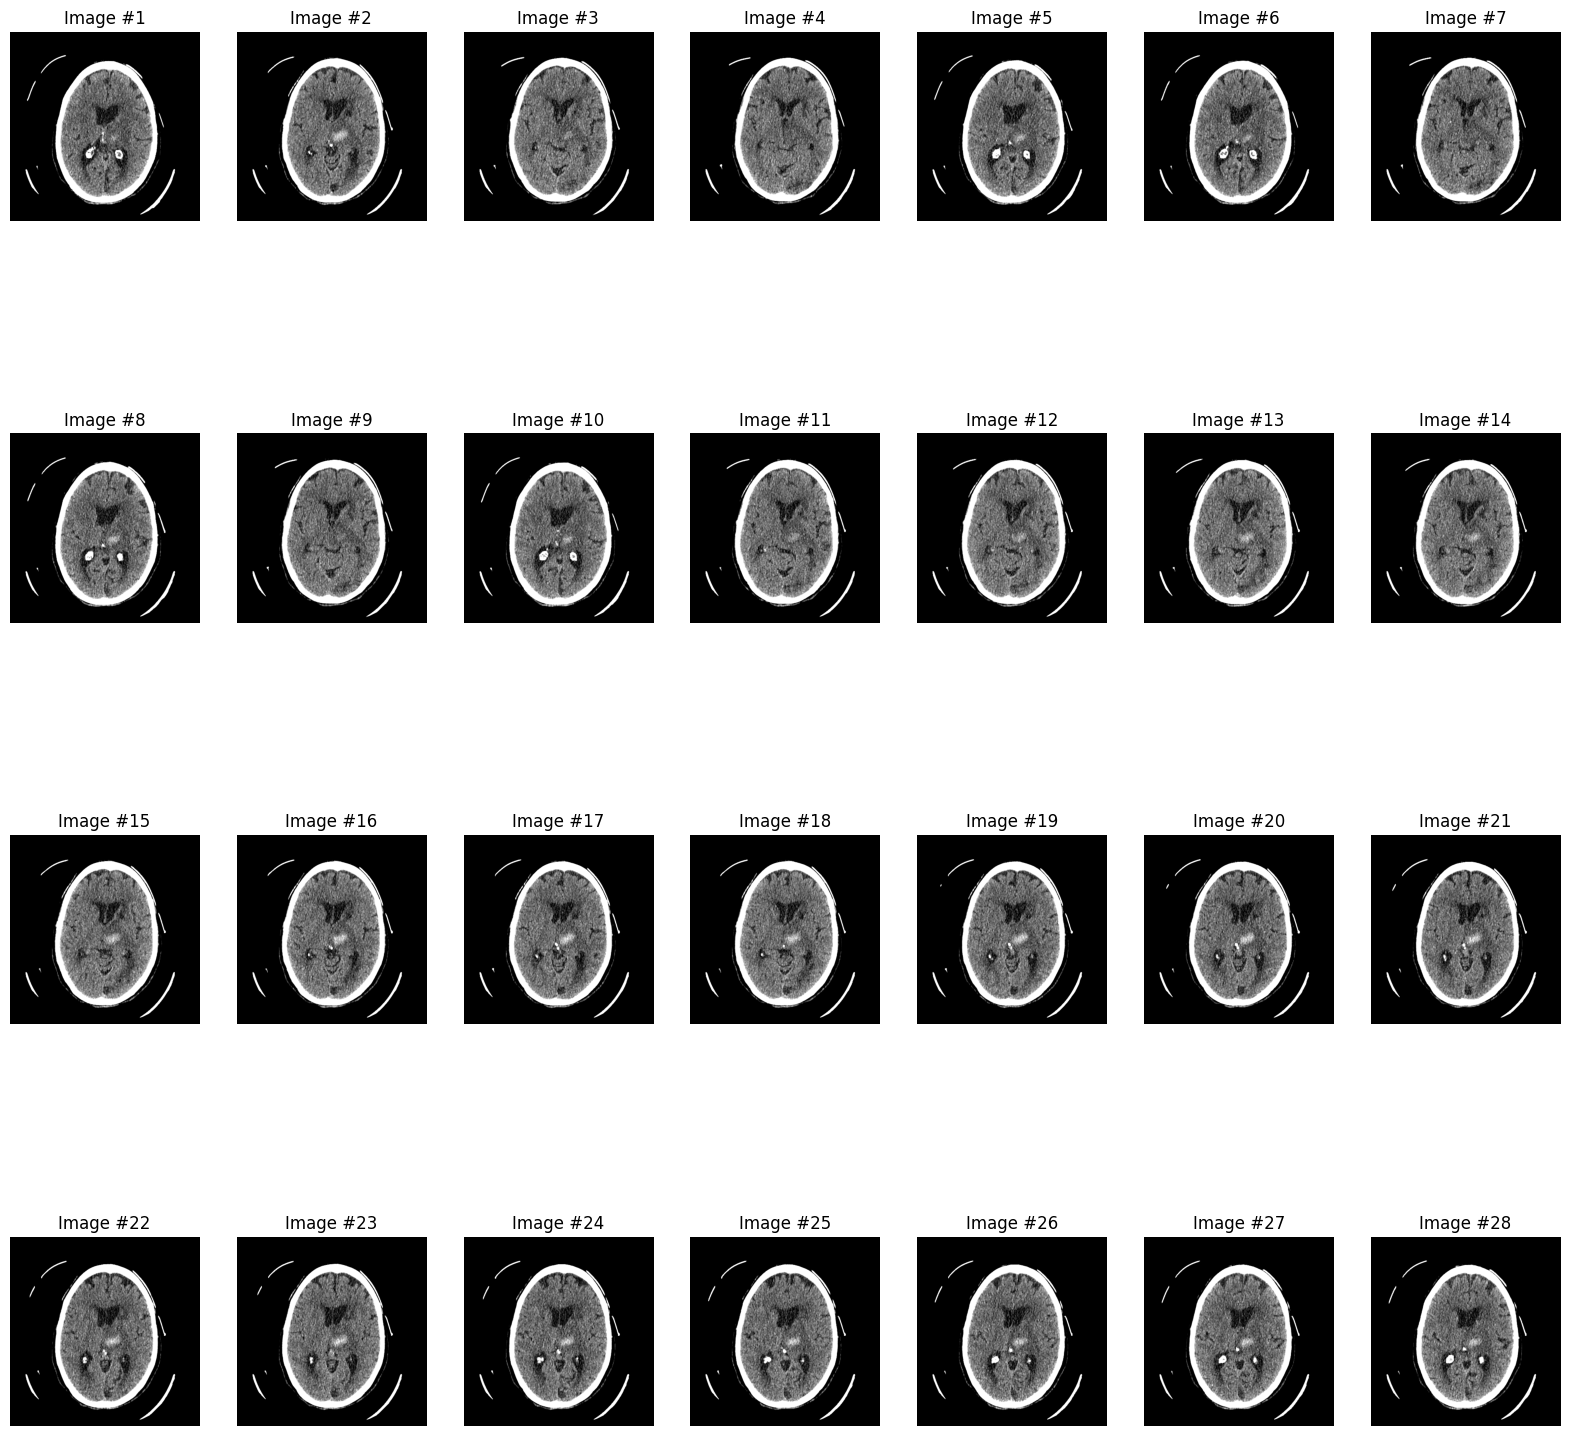

In [156]:
# Plot all the images in 7*4 grid
fig, ax = plt.subplots(4, 7, figsize=(20, 20))

for i in range(4):
    for j in range(7):
        ax[i, j].imshow(image_array[i*7+j], cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title('Image #{}'.format(i*7+j+1))

plt.show()

In [157]:
# Lists to store annotations and hemorrhage type labels
annotations = []
hemorrhage_labels = []

# Iterate through the 'labels' array, which contains both types of labels
for label_row in label_array:
    # Append the annotation data to the 'annotations' list
    annotations.append(label_row['data'])  # Replace 'Annotation_Column' with the actual column name for annotations
    # Append the hemorrhage type label to the 'hemorrhage_labels' list
    hemorrhage_labels.append(label_row['labelName'])  # Replace 'Hemorrhage_Type_Column' with the actual column name for hemorrhage types

In [158]:
print(annotations)

["{'x': 263.13482999999997, 'y': 268.94382, 'width': 45.30338, 'height': 39.55057}", "{'x': 248.03371, 'y': 255.2809, 'width': 64.7191, 'height': 58.96629}", "{'x': 257.38202, 'y': 257.4382, 'width': 48.17978, 'height': 45.30338}", "{'x': 270.32583, 'y': 265.34831, 'width': 29.48315, 'height': 33.07864}", "{'x': 260, 'y': 266, 'width': 49, 'height': 43}", "{'x': 262, 'y': 268, 'width': 47, 'height': 41}", "{'x': 266, 'y': 263, 'width': 36, 'height': 37}", "{'x': 259, 'y': 266, 'width': 50, 'height': 44}", "{'x': 262, 'y': 260, 'width': 42, 'height': 41}", "{'x': 261, 'y': 267, 'width': 48, 'height': 42}", "{'x': 256, 'y': 257, 'width': 50, 'height': 47}", "{'x': 255, 'y': 257, 'width': 52, 'height': 49}", "{'x': 253, 'y': 256, 'width': 56, 'height': 52}", "{'x': 254, 'y': 257, 'width': 54, 'height': 50}", "{'x': 252, 'y': 256, 'width': 59, 'height': 54}", "{'x': 249, 'y': 256, 'width': 63, 'height': 57}", "{'x': 249, 'y': 256, 'width': 64, 'height': 58}", "{'x': 250, 'y': 256, 'width':

In [159]:
import json
import pandas as pd

# Your list of JSON strings
json_strings = annotations

# Initialize lists to store the parsed values
x_values = []
y_values = []
width_values = []
height_values = []

# Parse the JSON strings and extract values
for json_str in json_strings:
    data = json.loads(json_str.replace("'", "\""))  # Ensure single quotes are replaced with double quotes
    x_values.append(data['x'])
    y_values.append(data['y'])
    width_values.append(data['width'])
    height_values.append(data['height'])

# Create a DataFrame to store the values
df = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'width': width_values,
    'height': height_values
})

# Save the DataFrame to a CSV file
df.to_csv('annotations.csv', index=False)




In [160]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


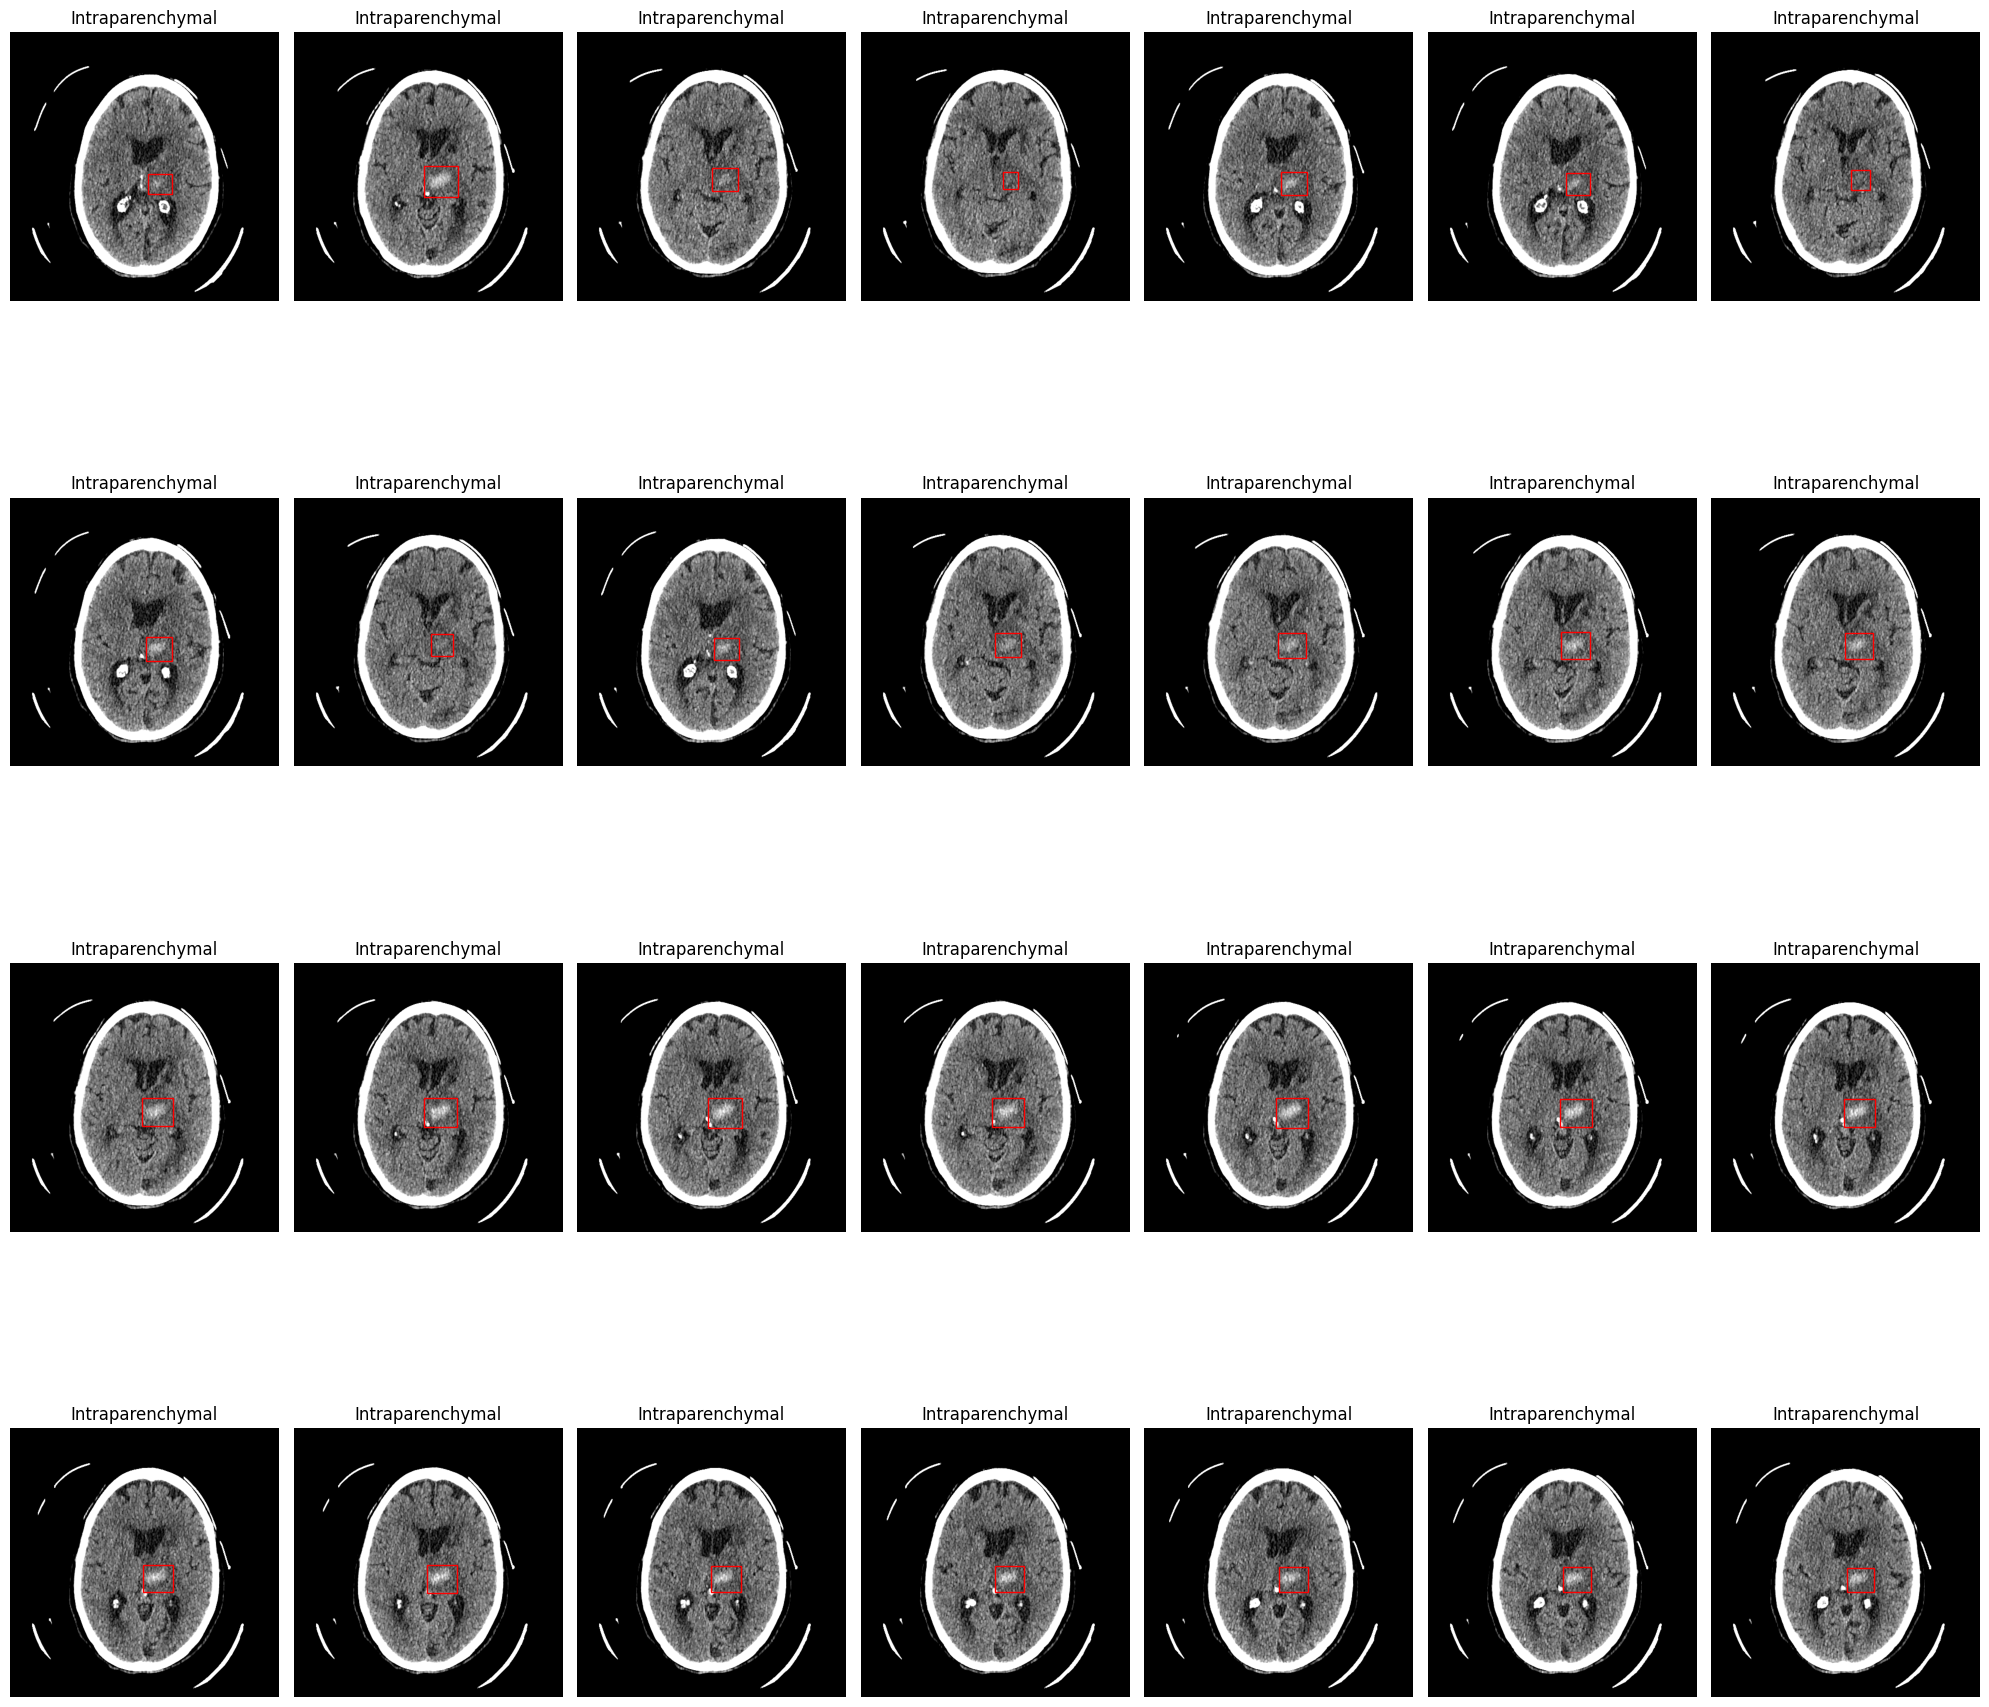

In [161]:
import math

# Calculate the number of rows and columns for the grid
num_images = len(image_array)
num_rows = min(4, math.ceil(num_images / 4))
num_columns = min(7, num_images)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))

annotations = pd.read_csv('annotations.csv')

# Iterate through the images, annotations, and labels
for i, (ct_image, (_, row), label) in enumerate(zip(image_array, annotations.iterrows(), label_array)):
    # Calculate the row and column index for the current subplot
    row_index = i // num_columns
    col_index = i % num_columns

    # Get the annotation data for the current image
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height']

    # Select the current subplot
    if num_images > 1:
        ax = axes[row_index, col_index]
    else:
        ax = axes  # If there is only one image, axes is a single subplot

    # Create a rectangle patch for the annotation
    rect = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )

    # Add the rectangle to the plot
    ax.imshow(ct_image, cmap='gray')
    ax.add_patch(rect)

    # Remove axis labels and set the title to the hemorrhage type label
    ax.axis('off')
    ax.set_title(label['labelName'])

# Remove any empty subplots
for i in range(num_images, num_rows * num_columns):
    row_index = i // num_columns
    col_index = i % num_columns
    fig.delaxes(axes[row_index, col_index])

# Adjust the layout
plt.tight_layout()

# Show the images with annotations and labels in a 7x4 grid
plt.show()


In [162]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_array, label_array, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# X_train, y_train: Training data and annotations
# X_val, y_val: Validation data and annotations
# X_test, y_test: Test data and annotations


In [163]:
print('X_train size: ',len(X_train))
print('y_train size: ',len(y_train))
print('X_val size: ',len(X_val))
print('y_val size: ',len(y_val))
print('X_test size: ',len(X_test))
print('y_test size: ',len(y_test))

X_train size:  19
y_train size:  19
X_val size:  4
y_val size:  4
X_test size:  5
y_test size:  5


In [164]:
import imgaug as ia
from imgaug import augmenters as iaa

# Define data augmentation parameters
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips with a 50% probability
    iaa.Affine(rotate=(-10, 10)),  # Random rotation between -10 and 10 degrees
    iaa.Multiply((0.7, 1.3), per_channel=0.2),  # Randomly change brightness
    iaa.GaussianBlur(sigma=(0, 1.0))  # Apply Gaussian blur with a random sigma
])

# Apply data augmentation to your training dataset
X_train_augmented = []
for image in X_train:
    augmented_image = seq.augment_image(image)
    X_train_augmented.append(augmented_image)

# Combine the original training data with augmented data
X_train_combined = np.vstack([X_train, X_train_augmented])
y_train_combined = np.hstack([y_train, y_train])  # Keep the labels the same

# Now, you can use X_train_combined and y_train_combined for training


In [165]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return len(self.data)
        return 19

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'label': self.labels[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Create instances of your custom dataset for training, validation, and testing
train_dataset = CustomDataset(X_train_combined, y_train_combined)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Define transformations if needed (e.g., ToTensor, normalization)
from torchvision import transforms
custom_transforms = transforms.Compose([transforms.ToTensor()])

# Apply transformations to datasets
train_dataset.transform = custom_transforms
val_dataset.transform = custom_transforms
test_dataset.transform = custom_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now, you can use train_loader, val_loader, and test_loader to iterate through your data during training.


In [167]:
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define your CustomDataset as before

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load a pre-trained ResNet model
model = torchvision.models.resnet50(pretrained=True)
# You can choose a different variant like resnet18, resnet34, resnet101, etc., depending on your needs.

# Freeze the pre-trained layers to prevent them from being trained
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes in your task
num_classes = len(y_train_combined[0])  # Replace with the actual number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 10  # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data['image'], data['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data['image'], data['label']
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        val_loss = running_loss / len(val_loader)
        val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Now you can evaluate the model on the test set and make predictions.


TypeError: pic should be PIL Image or ndarray. Got <class 'dict'>